## Running the DEEP AA on the Beta Cells dataset

In [31]:
import sys, scprep, magic, scanpy, sklearn
import warnings; warnings.filterwarnings('ignore')
sys.path.append('/Users/joaomata/Desktop/DTU/DeepLearning/ProjectDL/AAnet') # replace with location of AAnet from https://github.com/KrishnaswamyLab/AAnet
from AAnet_torch import * # use torch implementation
import torch; from torch import optim
import numpy as np
import matplotlib; import matplotlib.pyplot as plt
from sklearn import decomposition
import os
from itertools import combinations
from scipy.spatial.distance import squareform, pdist


### Global Setup

In [ ]:
np.random.seed(0)
N_ARCHETYPES = 4
N_RUNS = 5
N_EPOCHS = 10
N_PROTOTYPES = 4
SAVE_DIR = "results/beta_cells/AANET"


### Load the dataset

In [5]:

# 1. Load Data
print("Loading single-cell dataset...")
adata_beta_hfd = scanpy.read_h5ad('data/beta_cells_hfd.h5ad')

# show size of dataset
print(f"Dataset shape: {adata_beta_hfd.X.shape}")

adata_beta_hfd

Loading single-cell dataset...
Dataset shape: (3887, 16483)


AnnData object with n_obs × n_vars = 3887 × 16483
    obs: 'sample'
    var: 'human_name', 'ids'

### Subsample

In [15]:
# Dataset is too big, subsample for faster testing
adata_beta_hfd = adata_beta_hfd[:1000, :]
print(f"Subsampled dataset shape: {adata_beta_hfd.X.shape}")

Subsampled dataset shape: (1000, 16483)


### Apply Magic
Result: hfd_magic → imputed gene expression matrix with fewer zeros.

In [16]:
hfd_magic_op = magic.MAGIC(random_state=42, t=10)
hfd_magic = hfd_magic_op.fit_transform(adata_beta_hfd.to_df())

Calculating MAGIC...
  Running MAGIC on 1000 cells and 16483 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.75 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
    Calculated affinities in 0.07 seconds.
  Calculated graph and diffusion operator in 0.89 seconds.
  Running MAGIC with `solver='exact'` on 16483-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 0.45 seconds.
Calculated MAGIC in 1.48 seconds.


In [17]:
hfd_pc_op = decomposition.PCA(n_components=20, random_state=42)
hfd_magic_pc = hfd_pc_op.fit_transform(hfd_magic)

# Normalize for AAnet model
hfd_magic_pc_norm = hfd_magic_pc / np.std(hfd_magic_pc[:, 0])

# Print everything to debug
print(f"Magic Imputed Data Shape: {hfd_magic.shape}")
print(f"PCA Reduced Data Shape: {hfd_magic_pc.shape}")
print(f"Normalized Data Shape: {hfd_magic_pc_norm.shape}")

Magic Imputed Data Shape: (1000, 16483)
PCA Reduced Data Shape: (1000, 20)
Normalized Data Shape: (1000, 20)


### Run AAnet
AAnet performs much better with diffusion extrema initialization 


In [28]:
# Added a transposoition to ensure final shape
X = torch.tensor(hfd_magic_pc_norm, dtype=torch.float64).transpose(0, 1)

extrema = torch.Tensor(utils.get_laplacian_extrema(hfd_magic_pc_norm, n_extrema=N_ARCHETYPES, subsample=False))
extrema = torch.Tensor(hfd_magic_pc_norm[extrema.numpy().astype(int)])

In [19]:
device = torch.device('cpu')
model = models.AAnet_vanilla(noise=0.05, layer_widths=[256, 128],
                             n_archetypes=N_ARCHETYPES,
                             input_shape=hfd_magic_pc_norm.shape[1],
                             device=device, diffusion_extrema=extrema)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [20]:
data_loader = torch.utils.data.DataLoader(hfd_magic_pc_norm, batch_size=256, shuffle=True, num_workers=2)

In [ ]:
from tqdm import trange

S_list = []
C_list = []
L_list = []

os.makedirs(SAVE_DIR, exist_ok=True)

for run in range(N_RUNS):
    print(f"Run {run+1}/{N_RUNS}")

    # Train for N_EPOCHS
    # Train for N_EPOCHS with progress bar
    for epoch in trange(1, N_EPOCHS + 1, desc=f"Training Run {run+1}", leave=False):
        loss, r_loss, a_loss = utils.train_epoch(model, data_loader, optimizer, epoch=epoch, gamma_extrema=1.0)

    # Encode final embeddings
    archetypal_embedding = model.encode(torch.Tensor(hfd_magic_pc_norm)).detach().numpy()  # shape: (N_samples, k)
    print("archetypal_embedding shape:", archetypal_embedding.shape)

    # Convert k-1 embedding to k-dimensional barycentric coordinates
    barycentric_embedding = model.euclidean_to_barycentric(torch.Tensor(archetypal_embedding)).detach().numpy()
    
    # S: (archetypes × samples)
    S_T = barycentric_embedding.T # shape: (archetypes, samples)
    C = S_T.T              

    # Save run results
    S_list.append(S_T)
    C_list.append(C)
    
    print(f"Run {run+1} - S shape: {S_T.shape}, C shape: {C.shape}, X shape: {hfd_magic_pc_norm.shape}")  


    # Optional: save each run separately
    np.savez(os.path.join(SAVE_DIR, f'run{run+1}_results.npz'), S=S_T, C=C, X=hfd_magic_pc_norm)

# Save all runs together
torch.save({'S_list': S_list, 'C_list': C_list, 'X': hfd_magic_pc_norm}, os.path.join(SAVE_DIR, 'AAnet_singlecell_runs.pth'))
print("✅ Saved all runs results.")


Run 1/5


archetypal_embedding shape: (1000, 3)
Run 1 - S shape: (4, 1000), C shape: (1000, 4), X shape: (1000, 20)
Run 2/5


archetypal_embedding shape: (1000, 3)
Run 2 - S shape: (4, 1000), C shape: (1000, 4), X shape: (1000, 20)
Run 3/5


archetypal_embedding shape: (1000, 3)
Run 3 - S shape: (4, 1000), C shape: (1000, 4), X shape: (1000, 20)
Run 4/5


archetypal_embedding shape: (1000, 3)
Run 4 - S shape: (4, 1000), C shape: (1000, 4), X shape: (1000, 20)
Run 5/5


archetypal_embedding shape: (1000, 3)
Run 5 - S shape: (4, 1000), C shape: (1000, 4), X shape: (1000, 20)
✅ Saved all runs results.


## Visualize the Results

In [23]:
# Open the saved results to verify
results = torch.load('/Users/joaomata/Desktop/DTU/DeepLearning/ProjectDL/AAnet/example_notebooks/results/beta_Cells/AANET/AAnet_singlecell_runs.pth', weights_only=False)
print("Saved Results Keys:", results.keys())
print("Number of Runs Saved:", len(results['C_list']))

# Print shapes if the first run to verify
print("Shape of C in first run:", results['C_list'][0].shape)
print("Shape of S in first run:", results['S_list'][0].shape)
print('Shape of X in first run:', results['X'].shape)

Saved Results Keys: dict_keys(['S_list', 'C_list', 'X'])
Number of Runs Saved: 5
Shape of C in first run: (1000, 4)
Shape of S in first run: (4, 1000)
Shape of X in first run: (1000, 20)


# Metric Formulas

In [29]:
def to_numpy(tensor):
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()
    return tensor

def preprocess(X):
    meanX = np.mean(X, axis=0)
    X_centered = X - meanX
    mSST = np.sum(np.mean(X_centered**2, axis=0))
    return X_centered, mSST

def calcMI(z1, z2):
    eps = 10e-16
    P = z1 @ z2.T
    PXY = P / P.sum()
    PXPY = np.outer(np.expand_dims(PXY.sum(1), axis=0), np.expand_dims(PXY.sum(0), axis=1))
    ind = np.nonzero(PXY > 0)
    MI = np.sum(PXY * np.log(eps + PXY / (eps + PXPY)))
    return MI

def calcNMI(z1, z2):
    NMI = (2 * calcMI(z1, z2)) / (calcMI(z1, z1) + calcMI(z2, z2))
    return NMI

def ArchetypeConsistency(XC1, XC2, mSST):
    D = squareform(pdist(np.hstack((XC1, XC2)).T, 'euclidean'))**2
    D = D[:XC1.shape[1], XC1.shape[1]:]
    # Greedy matching
    i = []
    j = []
    v = []
    K = XC1.shape[1]
    for k in range(K):
        min_index = np.unravel_index(np.argmin(D, axis=None), D.shape)
        i.append(min_index[0])
        j.append(min_index[1])
        v.append(D[i[-1], j[-1]])
        D[i[-1], :] = np.inf
        D[:, j[-1]] = np.inf
    consistency = 1 - np.mean(v) / mSST
    D2 = np.abs(np.corrcoef(np.hstack((XC1, XC2)).T))
    D2 = D2[:K, K:]
    ISI = 1 / (2 * K * (K - 1)) * (np.sum(D2 / np.max(D2, axis=1, keepdims=True) + D2 / np.max(D2, axis=0, keepdims=True)) - 2 * K)
    return consistency, ISI

In [32]:

# Calculate metrics over the runs
C_matrices = [to_numpy(C) for C in results['C_list']]
print("C_matrices length:", len(C_matrices))
print("C_matrices[0] shape:", C_matrices[0].shape)
S_matrices = [to_numpy(S) for S in results['S_list']]
print("S_matrices length:", len(S_matrices))
print("S_matrices[0] shape:", S_matrices[0].shape)

X_centered, mSST = preprocess(to_numpy(X))

X_raw = to_numpy(X)

def compute_stability_metrics(S_list, C_list, X_raw, N_RUNS):
    """
    Compute pairwise stability metrics across runs.
    
    Returns:
        nmi_matrix, consistency_matrix, isi_matrix
    """
    X_centered, mSST_val = preprocess(X_raw)

    nmi_matrix = np.zeros((N_RUNS, N_RUNS))
    consistency_matrix = np.zeros((N_RUNS, N_RUNS))
    isi_matrix = np.zeros((N_RUNS, N_RUNS))

    for i, j in combinations(range(N_RUNS), 2):
        S_i, S_j = S_list[i], S_list[j]
        C_i, C_j = C_list[i], C_list[j]

        nmi_matrix[i, j] = calcNMI(S_i, S_j)
        consistency_matrix[i, j], isi_matrix[i, j] = ArchetypeConsistency(C_i, C_j, mSST_val)

    # Fill symmetric and diagonal
    nmi_matrix += nmi_matrix.T
    consistency_matrix += consistency_matrix.T
    isi_matrix += isi_matrix.T
    np.fill_diagonal(nmi_matrix, 1)
    np.fill_diagonal(consistency_matrix, 1)
    np.fill_diagonal(isi_matrix, 1)

    return nmi_matrix, consistency_matrix, isi_matrix

# --- Compute for Linear AA ---
nmi_linear, consistency_linear, isi_linear = compute_stability_metrics(S_matrices, C_matrices, X_raw, N_RUNS)

print("---")
print("Deep AANET AA 5-run stability:")
print("---")
print("Mean NMI:", np.mean(nmi_linear[np.triu_indices(N_RUNS, 1)]))
print("Mean Archetype Consistency:", np.mean(consistency_linear[np.triu_indices(N_RUNS, 1)]))
print("Mean ISI:", np.mean(isi_linear[np.triu_indices(N_RUNS, 1)]))


C_matrices length: 5
C_matrices[0] shape: (1000, 4)
S_matrices length: 5
S_matrices[0] shape: (4, 1000)
---
Deep AANET AA 5-run stability:
---
Mean NMI: 0.9619002101933717
Mean Archetype Consistency: 0.8207885264560622
Mean ISI: 0.37622600392945693


---

#### AAnet training results in the following useful outputs:

`barycentric_archetypal_embedding: n_obs x n_ats`: Archetypal affinity for each cell.  
`pc_ats: n_ats x n_pcs`: Embedding for each archetype based on input embedding (here we used PCs).   
`data_ats: n_ats x n_genes`: Ambient space measurement for each archetype by inverse transforming from PC space.

In [ ]:
archetypal_embedding = model.encode(torch.Tensor(hfd_magic_pc_norm))
barycentric_archetypal_embedding = model.euclidean_to_barycentric(archetypal_embedding).detach().numpy()
pc_ats = model.decode(model.get_n_simplex(model.n_archetypes).type(torch.float)).cpu().detach().numpy()
data_ats = ((pc_ats * np.std(hfd_magic_pc[:,0])) @ hfd_pc_op.components_)

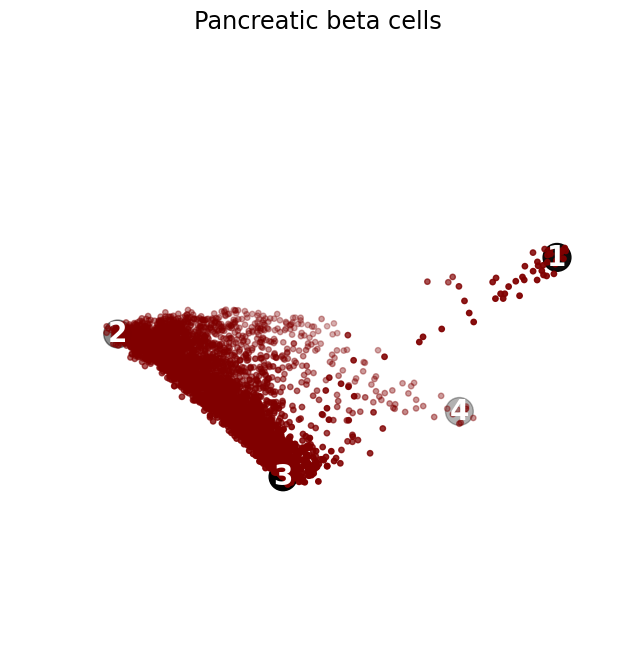

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

scprep.plot.scatter3d(hfd_magic_pc_norm, c=color,
                          ylabel=None, zorder=1, s=15,
                          title=tissue, colorbar=False, ax=ax)

scprep.plot.scatter3d(pc_ats, ax=ax, c='black', s=400, figsize=(10,10), colorbar=False,azim=azim,)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
ax.axis('off')
for t,coord in enumerate(pc_ats):
        ax.text(coord[0], coord[1], coord[2], s=t+1, horizontalalignment='center',
                        verticalalignment='center', fontdict={'color': 'white','size':20,'weight':'bold'}, zorder=4)

## Save model and outputs

In [33]:
torch.save(model.state_dict(), f'results/Beta_cells_model_state_dict')

In [ ]:
np.savez(f'results/Beta_cell_AAnet_results.npz', data_ats=data_ats, pc_ats=pc_ats, latent_coords=barycentric_archetypal_embedding)